# Homework lab3

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## 1 Data reading

In [2]:
DATA_DIR = "data"

In [25]:
dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)

df_2024 = pl.concat(dfs)

df_2024 = df_2024.filter(pl.col("tpep_pickup_datetime").dt.year() >= 2024).filter(
    pl.col("tpep_dropoff_datetime").dt.date() <= pl.date(year=2025, month=1, day=1)
)

df_2024 = df_2024.with_columns(
    pl.col("VendorID").cast(pl.UInt8),
    pl.col("passenger_count").cast(pl.UInt8),
    pl.col("PULocationID").cast(pl.UInt16),
    pl.col("DOLocationID").cast(pl.UInt16),
    pl.col("RatecodeID").cast(pl.UInt8),
    (pl.col("store_and_fwd_flag") == "Y").cast(pl.Boolean),
    pl.col("payment_type").cast(pl.UInt8),
)

In [4]:
df_taxi_zones = pl.scan_csv("data/taxi_zone_lookup.csv")

## 2 Data cleaning and filtering

In [38]:
trip_time = (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).alias(
    "trip_time"
)

money_columns = pl.col(
    [
        "fare_amount",
        "extra",
        "mta_tax",
        "tip_amount",
        "tolls_amount",
        "improvement_surcharge",
        "total_amount",
        "congestion_surcharge",
        "Airport_fee",
    ]
)

df_2024 = (
    df_2024.with_columns(
        pl.col("passenger_count").fill_null(value=1)
    )  # passenger count fix
    .filter(pl.col("passenger_count") > 0)
    .with_columns(pl.col("passenger_count").replace([7, 8, 9], [6, 6, 6]))
    .filter(trip_time.dt.total_minutes() <= 120)  # trip time less than 2h
    .with_columns(money_columns.abs())  # negative payments
    .filter(pl.max_horizontal(money_columns) < 1000)
    .filter(pl.col("VendorID").is_in([1, 2, 6, 7]))  # clear from unknown IDs
    .filter(pl.col("RatecodeID").is_in(list(range(1, 7)) + [99]))
)

## 3 Data transformation

In [56]:
unnecessary_columns = pl.col(["Zone", "Borough", "service_zone"])

df_2024 = (
    df_2024.with_columns(
        pl.col("payment_type").replace([4, 5, 6], [3, 3, 3])
    )  # 3 - no charge -> other
    .join(  # PULocations
        df_taxi_zones, left_on="PULocationID", right_on="LocationID"
    )
    .with_columns(pl.col("Borough").alias("PULocationID"))
    .drop(unnecessary_columns)
    .join(  # DOLocationID
        df_taxi_zones, left_on="DOLocationID", right_on="LocationID"
    )
    .with_columns(pl.col("Borough").alias("DOLocationID"))
    .drop(unnecessary_columns)
    .with_columns((pl.col("Airport_fee") > 0).alias("is_airport_ride"))  # airport
    .with_columns(
        (  # literally don't know if there is better way for intersecting line segment
            (
                (pl.col("tpep_pickup_datetime").dt.time() >= pl.time(hour=6, minute=30))
                & (
                    pl.col("tpep_pickup_datetime").dt.time()
                    <= pl.time(hour=9, minute=30)
                )
            )
            | (
                (
                    pl.col("tpep_dropoff_datetime").dt.time()
                    >= pl.time(hour=6, minute=30)
                )
                & (
                    pl.col("tpep_dropoff_datetime").dt.time()
                    <= pl.time(hour=9, minute=30)
                )
            )
            | (
                (
                    pl.col("tpep_pickup_datetime").dt.time()
                    >= pl.time(hour=15, minute=30)
                )
                & (
                    pl.col("tpep_pickup_datetime").dt.time()
                    <= pl.time(hour=20, minute=00)
                )
                & pl.col("tpep_pickup_datetime").dt.weekday().is_in([6, 7])
            )
            | (
                (
                    pl.col("tpep_dropoff_datetime").dt.time()
                    >= pl.time(hour=15, minute=30)
                )
                & (
                    pl.col("tpep_dropoff_datetime").dt.time()
                    <= pl.time(hour=20, minute=00)
                )
                & pl.col("tpep_pickup_datetime").dt.weekday().is_in([6, 7])
            )
        ).alias("is_rush_hour")
    )
)

## 4 Feature extraction

In [62]:
df_2024.collect_schema()

Schema([('VendorID', UInt8),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Boolean),
        ('PULocationID', String),
        ('DOLocationID', String),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64),
        ('is_airport_ride', Boolean),
        ('is_rush_hour', Boolean)])

In [ ]:
# dummies are not possible without collecting
df: pl.DataFrame = df_2024.collect()

In [ ]:
# dummies and back to lazy
df = df.to_dummies(["payment_type", "PULocationID", "DOLocationID"])
lf = df.lazy()

In [76]:
# daily variables and aggregations

daily_counts = (
    lf.with_columns(pl.col("tpep_dropoff_datetime").dt.date().alias("date"))
    .group_by("date")
    .agg(
        [
            pl.count().alias("total_daily_rides"),
            pl.sum("is_airport_ride").alias("num_daily_airport_rides"),
            pl.sum("is_rush_hour").alias("num_daily_rush_hour_rides"),
            pl.mean("fare_amount").alias("average_daily_fare_amount"),
            pl.median("trip_distance").alias("median_daily_trip_distance"),
            pl.sum("total_amount").alias("sum_daily_total_amount"),
            pl.sum("passenger_count").alias("sum_daily_passenger_count"),
        ]
    )
)


final_lf = (
    lf.with_columns(
        pl.col("tpep_pickup_datetime").dt.date().alias("date")
    )  # join to daily aggregations (adds 'date')
    .join(daily_counts, left_on="date", right_on="date")
    .with_columns(
        [
            pl.col("date").dt.quarter().alias("quarter"),  # add time features
            pl.col("date").dt.month().alias("month"),
            pl.col("date").dt.day().alias("day_of_month"),
            pl.col("date").dt.weekday().alias("day_of_week"),
            (pl.col("date").dt.weekday().is_in([6, 7])).alias("is_weekend"),
        ]
    )
    .drop(["VendorID", "RatecodeID", "tpep_pickup_datetime", "tpep_dropoff_datetime"])
)

final_lf.collect_schema()

/tmp/ipykernel_8795/186216319.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("total_daily_rides"),


Schema([('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('store_and_fwd_flag', Boolean),
        ('PULocationID_Bronx', UInt8),
        ('PULocationID_Brooklyn', UInt8),
        ('PULocationID_EWR', UInt8),
        ('PULocationID_Manhattan', UInt8),
        ('PULocationID_N/A', UInt8),
        ('PULocationID_Queens', UInt8),
        ('PULocationID_Staten Island', UInt8),
        ('PULocationID_Unknown', UInt8),
        ('DOLocationID_Bronx', UInt8),
        ('DOLocationID_Brooklyn', UInt8),
        ('DOLocationID_EWR', UInt8),
        ('DOLocationID_Manhattan', UInt8),
        ('DOLocationID_N/A', UInt8),
        ('DOLocationID_Queens', UInt8),
        ('DOLocationID_Staten Island', UInt8),
        ('DOLocationID_Unknown', UInt8),
        ('payment_type_1', UInt8),
        ('payment_type_2', UInt8),
        ('payment_type_3', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
     

In [77]:
final_lf.collect().write_parquet("dataset.parquet")

## 5 Data analysis

In [2]:
df = pl.read_parquet("dataset.parquet")

In [3]:
df.shape

(36636602, 46)

In [4]:
df.head(5)

passenger_count,trip_distance,store_and_fwd_flag,PULocationID_Bronx,PULocationID_Brooklyn,PULocationID_EWR,PULocationID_Manhattan,PULocationID_N/A,PULocationID_Queens,PULocationID_Staten Island,PULocationID_Unknown,DOLocationID_Bronx,DOLocationID_Brooklyn,DOLocationID_EWR,DOLocationID_Manhattan,DOLocationID_N/A,DOLocationID_Queens,DOLocationID_Staten Island,DOLocationID_Unknown,payment_type_1,payment_type_2,payment_type_3,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,is_airport_ride,is_rush_hour,date,total_daily_rides,num_daily_airport_rides,num_daily_rush_hour_rides,average_daily_fare_amount,median_daily_trip_distance,sum_daily_total_amount,sum_daily_passenger_count,quarter,month,day_of_month,day_of_week,is_weekend
u8,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,date,u32,u32,u32,f64,f64,f64,i64,i8,i8,i8,i8,bool
1,1.72,false,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0,false,false,2024-01-01,69345,8184,3225,22.118132,2.08,2.1662e6,108664,1,1,1,1,false
1,1.8,false,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,false,false,2024-01-01,69345,8184,3225,22.118132,2.08,2.1662e6,108664,1,1,1,1,false
1,4.7,false,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0,false,false,2024-01-01,69345,8184,3225,22.118132,2.08,2.1662e6,108664,1,1,1,1,false
1,1.4,false,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,false,false,2024-01-01,69345,8184,3225,22.118132,2.08,2.1662e6,108664,1,1,1,1,false
1,0.8,false,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,false,false,2024-01-01,69345,8184,3225,22.118132,2.08,2.1662e6,108664,1,1,1,1,false


In [5]:
df.describe()

statistic,passenger_count,trip_distance,store_and_fwd_flag,PULocationID_Bronx,PULocationID_Brooklyn,PULocationID_EWR,PULocationID_Manhattan,PULocationID_N/A,PULocationID_Queens,PULocationID_Staten Island,PULocationID_Unknown,DOLocationID_Bronx,DOLocationID_Brooklyn,DOLocationID_EWR,DOLocationID_Manhattan,DOLocationID_N/A,DOLocationID_Queens,DOLocationID_Staten Island,DOLocationID_Unknown,payment_type_1,payment_type_2,payment_type_3,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,is_airport_ride,is_rush_hour,date,total_daily_rides,num_daily_airport_rides,num_daily_rush_hour_rides,average_daily_fare_amount,median_daily_trip_distance,sum_daily_total_amount,sum_daily_passenger_count,quarter,month,day_of_month,day_of_week,is_weekend
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,"""36636602""",3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7,3.6636602e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.3483,3.501378,0.004331,0.002061,0.008817,0.00016,0.88423,0.000601,0.100982,0.000026,0.003123,0.005897,0.040053,0.002843,0.889552,0.004844,0.052074,0.000252,0.004485,0.821617,0.149092,0.029292,19.914955,1.547176,0.493483,3.596026,0.619943,0.992078,29.084412,2.299784,0.156977,0.089701,0.175017,"""2024-07-05 02:33:48.998000""",102429.070632,9008.594048,17625.069282,19.913545,1.709703,2.9775e6,137606.470644,2.53996,6.636379,15.621336,3.989952,0.271339
"""std""",0.807488,85.857096,null,0.045351,0.093481,0.012635,0.319948,0.024514,0.301305,0.005076,0.055799,0.076565,0.196084,0.05324,0.313447,0.06943,0.222177,0.015884,0.066817,0.382835,0.356179,0.168623,18.829116,1.815963,0.057171,4.141057,2.283371,0.088541,23.506745,0.678566,0.500067,null,null,null,14778.380627,1661.093118,10873.442753,1.157162,0.096407,450161.628972,18280.677924,1.125084,3.461956,8.69732,1.933305,null
"""min""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""2024-01-01""",47505.0,3405.0,2335.0,16.690398,1.5,1.3288e6,74385.0,1.0,1.0,1.0,1.0,0.0
"""25%""",1.0,1.0,null,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.3,0.0,0.5,1.0,0.0,1.0,15.96,2.5,0.0,null,null,"""2024-04-05""",92165.0,7916.0,10997.0,19.11441,1.66,2.6721e6,124849.0,2.0,4.0,8.0,2.0,null
"""50%""",1.0,1.7,null,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.5,1.0,0.5,2.86,0.0,1.0,21.0,2.5,0.0,null,null,"""2024-07-03""",103610.0,9037.0,12397.0,19.886978,1.7,2.9742e6,137581.0,3.0,7.0,16.0,4.0,null
"""75%""",1.0,3.27,null,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.9,2.5,0.5,4.45,0.0,1.0,30.94,2.5,0.0,null,null,"""2024-10-08""",111998.0,10181.0,27227.0,20.651367,1.75,3.2731e6,149368.0,4.0,10.0,23.0,6.0,null
"""max""",6.0,160244.91,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,998.0,16.19,35.84,747.47,528.56,1.0,999.0,2.52,1.75,1.0,1.0,"""2024-12-31""",141273.0,14841.0,48767.0,24.406711,2.2,4.4176e6,199072.0,4.0,12.0,31.0,7.0,1.0


In [6]:
df.schema

Schema([('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('store_and_fwd_flag', Boolean),
        ('PULocationID_Bronx', UInt8),
        ('PULocationID_Brooklyn', UInt8),
        ('PULocationID_EWR', UInt8),
        ('PULocationID_Manhattan', UInt8),
        ('PULocationID_N/A', UInt8),
        ('PULocationID_Queens', UInt8),
        ('PULocationID_Staten Island', UInt8),
        ('PULocationID_Unknown', UInt8),
        ('DOLocationID_Bronx', UInt8),
        ('DOLocationID_Brooklyn', UInt8),
        ('DOLocationID_EWR', UInt8),
        ('DOLocationID_Manhattan', UInt8),
        ('DOLocationID_N/A', UInt8),
        ('DOLocationID_Queens', UInt8),
        ('DOLocationID_Staten Island', UInt8),
        ('DOLocationID_Unknown', UInt8),
        ('payment_type_1', UInt8),
        ('payment_type_2', UInt8),
        ('payment_type_3', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
     

In [8]:
rides_per_day = df.group_by("date").agg(pl.first("total_daily_rides")).to_pandas()

<Axes: xlabel='total_daily_rides', ylabel='Count'>

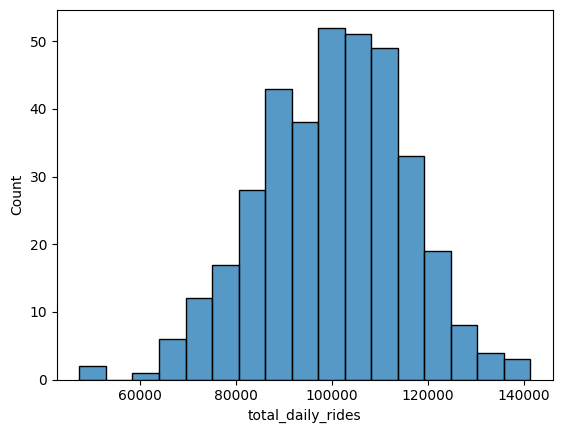

In [9]:
sns.histplot(data=rides_per_day, x="total_daily_rides")

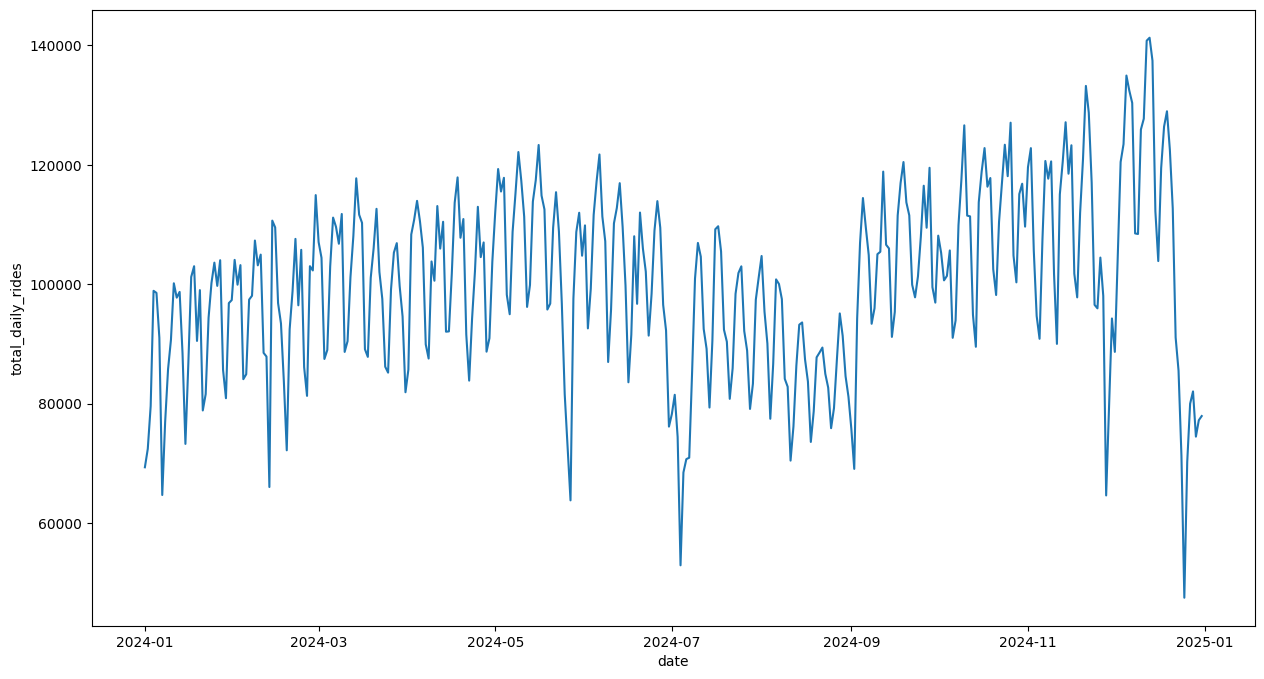

In [11]:
sns.lineplot(data=rides_per_day, x="date", y="total_daily_rides")
plt.gcf().set_size_inches(15, 8)